In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [2]:
random_seed = 42

In [3]:
class Result:
    def __init__(self, tag):
        self.model_tag = tag
        self.test_loss = None
        self.test_accuracy = None
        self.y_pred = None
        self.y_test = None
        self.y_pred_smote = None
        self.y_test_smote = None
        self.model_history = None

In [4]:
df = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB


In [6]:
df.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

In [7]:
# Simple Imputing
imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['SES']])
df[['SES']] = imputer.fit_transform(df[['SES']])

imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['CDR']])
df[['CDR']] = imputer.fit_transform(df[['CDR']])

imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['MMSE']])
df[['MMSE']] = imputer.fit_transform(df[['MMSE']])

imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['Educ']])
df[['Educ']] = imputer.fit_transform(df[['Educ']])

In [8]:
df.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ       0
SES        0
MMSE       0
CDR        0
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

In [9]:
df.drop(columns=['ID','Delay'],inplace=True)
df['CDR'].value_counts()

0.0    336
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

In [10]:
df.loc[df['CDR'] == 2,'CDR'] = 1

In [11]:
df['CDR'].value_counts()

0.0    336
0.5     70
1.0     30
Name: CDR, dtype: int64

In [12]:
y = df.pop('CDR')
x = np.array(df)
y = [i*2 for i in y]

In [13]:
results = []

In [14]:
input_layer = keras.Input(shape = (x.shape[1]))
x0 = layers.Dense(16, activation='relu')(input_layer)
x1 = layers.Dense(16, activation='relu')(x0)
x2 = layers.Dense(16, activation='relu')(x0)
x3 = layers.Dense(16, activation='relu')(x0)
x4 = layers.Concatenate()([x1, x2, x3])
x5 = layers.Dense(16, activation='relu')(x3)
x6 = layers.Dense(16, activation='relu')(x2)
x7 = layers.Concatenate()([x1, x5, x6])
x8 = layers.Concatenate()([x0, x4, x7])
x9 = layers.Dense(16, activation='relu')(x8)
output = layers.Dense(3, activation="softmax")(x9)

2022-12-09 01:55:28.732005: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
for i, (train_index, test_index) in enumerate(skf.split(x, y)):
    X_train = [x[i] for i in train_index]
    X_test = [x[i] for i in test_index]
    
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    
    ohe = OneHotEncoder(sparse=False)
    y_train = np.array([[y[i]] for i in train_index])
    y_test = np.array([[y[i]] for i in test_index])
    y_train = ohe.fit_transform(y_train)
    y_test = ohe.transform(y_test)

    # Label Encoding
    le = LabelEncoder()
    X_train[1] = le.fit_transform(X_train[1].values)
    X_test[1] = le.transform(X_test[1].values)
    le = LabelEncoder()
    X_train[0] = le.fit_transform(X_train[0].values)
    X_test[0] = le.transform(X_test[0].values)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    sm = SMOTE(random_state = random_seed)
    x_smote, y_smote = sm.fit_resample(X_train, y_train)
    x_train_smote, x_val_smote, y_train_smote, y_val_smote = train_test_split(x_smote, y_smote, test_size = 0.2, random_state = random_seed, stratify = y_smote)
    train_loader = tf.data.Dataset.from_tensor_slices((x_train_smote, y_train_smote))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val_smote, y_val_smote))
    
    model = keras.Model(inputs=input_layer, outputs=output)
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True) 
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["acc"])

    batch_size = 16
    train_dataset = (
        train_loader.shuffle(len(x_train_smote))
        .batch(batch_size)
        .prefetch(16)
    )

    validation_dataset = (
        validation_loader.shuffle(len(x_val_smote))
        .batch(batch_size)
        .prefetch(16)
    )
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"text_classification_{i}.h5", save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
    
    epochs = 100
    model_history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb]
    )
    
    model.load_weights(f"text_classification_{i}.h5")
    res = Result(f'text_classification_{i}')
    res.test_loss, res.test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)
    res.y_pred = []
    res.y_test = []

    for i in list(y_pred):
        t = list(i)
        k = t.index(max(t))
        res.y_pred.append(k)

    for i in list(y_test):
        t = list(i)
        k = t.index(max(t))
        res.y_test.append(k)
        
    nsm = SMOTE(random_state = random_seed)
    x_test_smote, y_test_smote = nsm.fit_resample(X_test, y_test)
    y_pred_smote = model.predict(x_test_smote)

    res.y_pred_smote = []
    res.y_test_smote = []

    for i in list(y_pred_smote):
        t = list(i)
        k = t.index(max(t))
        res.y_pred_smote.append(k)

    for i in list(y_test_smote):
        t = list(i)
        k = t.index(max(t))
        res.y_test_smote.append(k)
        
    res.model_history = model_history.history
    results.append(res)
    print('*----------*----------*----------*----------*----------*----------*----------*----------*----------*----------*')

Epoch 1/100


2022-12-09 01:55:31.959423: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


41/41 [==============================] - 1s 8ms/step - loss: 1.0181 - acc: 0.4510 - val_loss: 0.8797 - val_acc: 0.5590
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 0.7632 - acc: 0.6921 - val_loss: 0.6256 - val_acc: 0.7453
Epoch 3/100
41/41 [==============================] - 0s 3ms/step - loss: 0.5855 - acc: 0.7574 - val_loss: 0.4876 - val_acc: 0.8012
Epoch 4/100
41/41 [==============================] - 0s 3ms/step - loss: 0.5050 - acc: 0.7916 - val_loss: 0.4302 - val_acc: 0.8323
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 0.4628 - acc: 0.8243 - val_loss: 0.3984 - val_acc: 0.8696
Epoch 6/100
41/41 [==============================] - 0s 3ms/step - loss: 0.4378 - acc: 0.8212 - val_loss: 0.3720 - val_acc: 0.8634
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 0.4089 - acc: 0.8383 - val_loss: 0.3572 - val_acc: 0.8758
Epoch 8/100
41/41 [==============================] - 0s 3ms/step - loss: 0.3887 - acc: 0.8491 -

Test Loss:  0.4283938705921173
Test Accuracy:  0.8522727489471436
----------------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        68
           1       0.56      0.71      0.63        14
           2       0.38      0.50      0.43         6

    accuracy                           0.85        88
   macro avg       0.64      0.71      0.67        88
weighted avg       0.89      0.85      0.87        88

----------------------------------


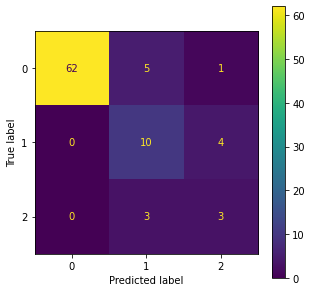

----------------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        68
           1       0.53      0.72      0.61        68
           2       0.60      0.44      0.51        68

    accuracy                           0.69       204
   macro avg       0.71      0.69      0.69       204
weighted avg       0.71      0.69      0.69       204

----------------------------------


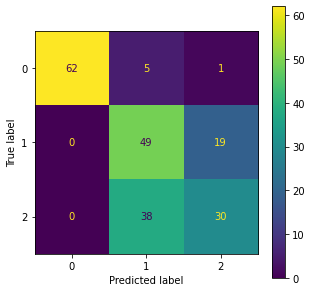

-----------------------------------


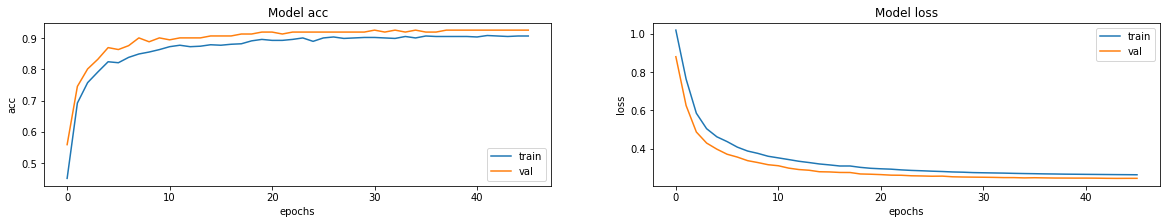

In [22]:
# For first fold
r1 = results[0]
print('Test Loss: ', r1.test_loss)
print('Test Accuracy: ', r1.test_accuracy)
print('----------------------------------')
print(classification_report(r1.y_test, r1.y_pred))
print('----------------------------------')
cm = confusion_matrix(r1.y_test, r1.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r1.y_test_smote, r1.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r1.y_test_smote, r1.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('-----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r1.model_history[metric])
    ax[i].plot(r1.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.5235754251480103
Test Accuracy:  0.7931034564971924
----------------------------------
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        67
           1       0.40      0.57      0.47        14
           2       0.33      0.33      0.33         6

    accuracy                           0.79        87
   macro avg       0.57      0.60      0.58        87
weighted avg       0.83      0.79      0.81        87

----------------------------------


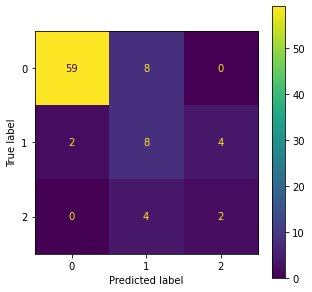

----------------------------------
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        67
           1       0.59      0.61      0.60        67
           2       0.69      0.69      0.69        67

    accuracy                           0.73       201
   macro avg       0.73      0.73      0.73       201
weighted avg       0.73      0.73      0.73       201

----------------------------------


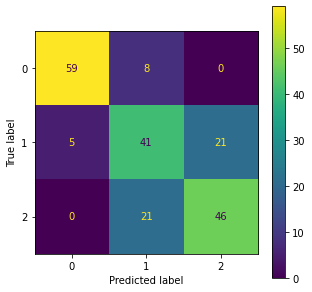

----------------------------------


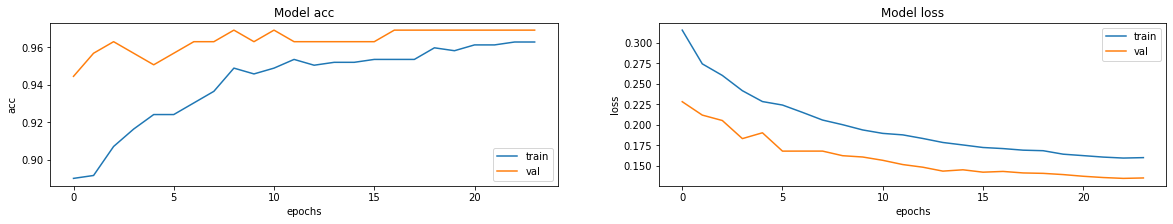

In [24]:
# For second fold
r2 = results[1]
print('Test Loss: ', r2.test_loss)
print('Test Accuracy: ', r2.test_accuracy)
print('----------------------------------')
print(classification_report(r2.y_test, r2.y_pred))
print('----------------------------------')
cm = confusion_matrix(r2.y_test, r2.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r2.y_test_smote, r2.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r2.y_test_smote, r2.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r2.model_history[metric])
    ax[i].plot(r2.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.24307286739349365
Test Accuracy:  0.9195402264595032
----------------------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        67
           1       0.71      0.86      0.77        14
           2       0.83      0.83      0.83         6

    accuracy                           0.92        87
   macro avg       0.84      0.88      0.86        87
weighted avg       0.93      0.92      0.92        87

----------------------------------


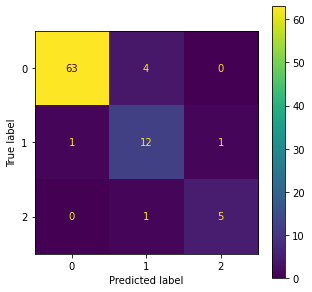

----------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        67
           1       0.92      0.85      0.88        67
           2       0.92      0.99      0.95        67

    accuracy                           0.93       201
   macro avg       0.93      0.93      0.92       201
weighted avg       0.93      0.93      0.92       201

----------------------------------


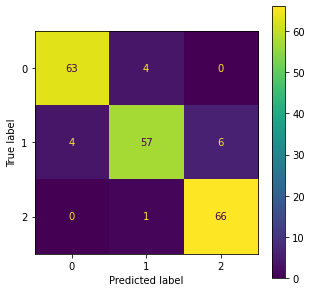

----------------------------------


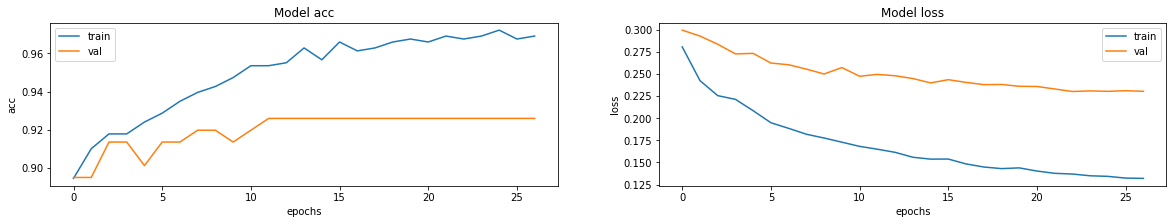

In [25]:
# For third fold
r3 = results[2]
print('Test Loss: ', r3.test_loss)
print('Test Accuracy: ', r3.test_accuracy)
print('----------------------------------')
print(classification_report(r3.y_test, r3.y_pred))
print('----------------------------------')
cm = confusion_matrix(r3.y_test, r3.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r3.y_test_smote, r3.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r3.y_test_smote, r3.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r3.model_history[metric])
    ax[i].plot(r3.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.2482765018939972
Test Accuracy:  0.8620689511299133
----------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        67
           1       0.62      0.57      0.59        14
           2       1.00      0.83      0.91         6

    accuracy                           0.86        87
   macro avg       0.84      0.78      0.80        87
weighted avg       0.86      0.86      0.86        87

----------------------------------


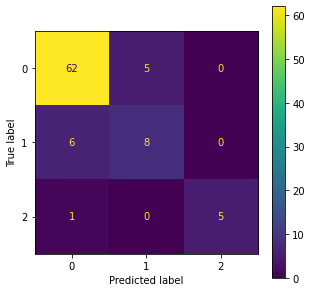

----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.93      0.78        67
           1       0.84      0.57      0.68        67
           2       0.97      0.94      0.95        67

    accuracy                           0.81       201
   macro avg       0.83      0.81      0.81       201
weighted avg       0.83      0.81      0.81       201

----------------------------------


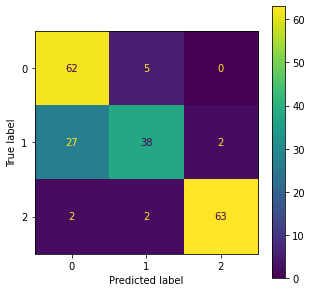

----------------------------------


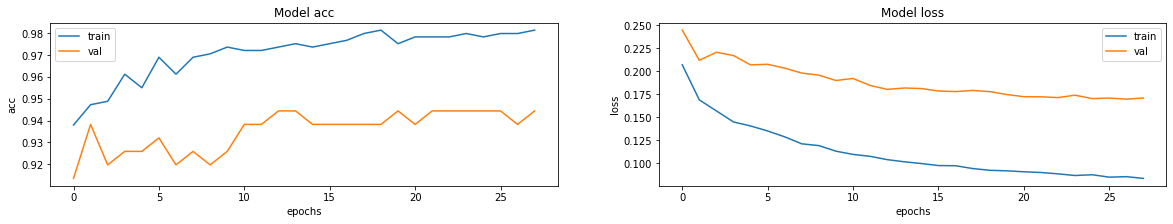

In [26]:
# For fourth fold
r4 = results[3]
print('Test Loss: ', r4.test_loss)
print('Test Accuracy: ', r4.test_accuracy)
print('----------------------------------')
print(classification_report(r4.y_test, r4.y_pred))
print('----------------------------------')
cm = confusion_matrix(r4.y_test, r4.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r4.y_test_smote, r4.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r4.y_test_smote, r4.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r4.model_history[metric])
    ax[i].plot(r4.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.23086896538734436
Test Accuracy:  0.8965517282485962
----------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        67
           1       0.65      0.79      0.71        14
           2       0.75      0.50      0.60         6

    accuracy                           0.90        87
   macro avg       0.79      0.75      0.76        87
weighted avg       0.90      0.90      0.90        87

----------------------------------


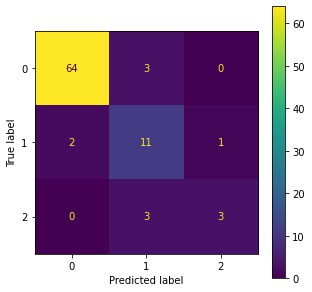

----------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        67
           1       0.67      0.84      0.74        67
           2       0.86      0.63      0.72        67

    accuracy                           0.81       201
   macro avg       0.82      0.81      0.80       201
weighted avg       0.82      0.81      0.80       201

----------------------------------


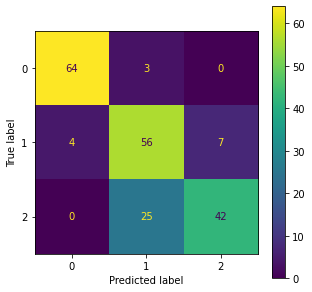

----------------------------------


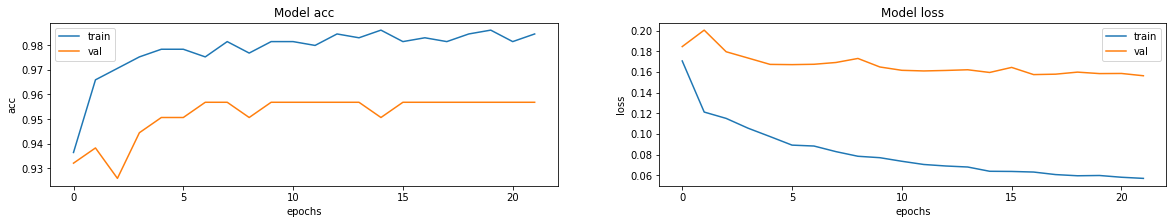

In [27]:
# For fifth fold
r5 = results[4]
print('Test Loss: ', r5.test_loss)
print('Test Accuracy: ', r5.test_accuracy)
print('----------------------------------')
print(classification_report(r5.y_test, r5.y_pred))
print('----------------------------------')
cm = confusion_matrix(r5.y_test, r5.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r5.y_test_smote, r5.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r5.y_test_smote, r5.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r5.model_history[metric])
    ax[i].plot(r5.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [29]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           160         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           272         dense[0][0]                      
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           272         dense[0][0]                      
____________________________________________________________________________________________

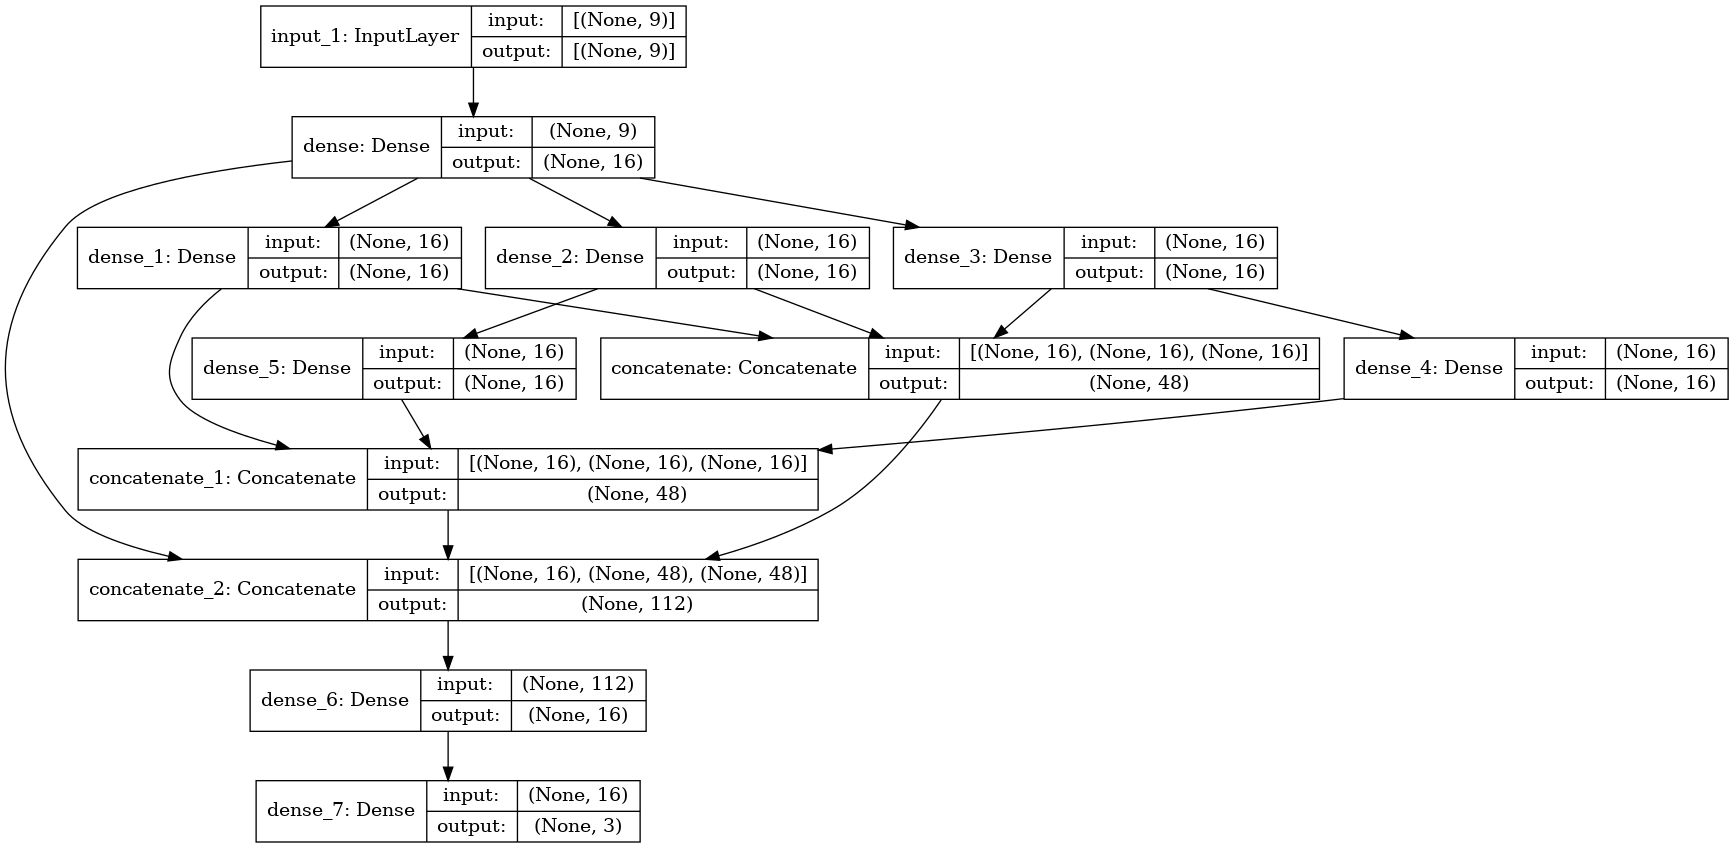

In [30]:
keras.utils.plot_model(model, to_file='text-model.png', show_shapes=True, show_layer_names=True)